# *(Tian, et al., 2020)* E/I Net for fast response

Implementation of the paper： 

- *Tian, Gengshuo, et al. "Excitation-Inhibition Balanced Neural Networks for Fast Signal Detection." Frontiers in Computational Neuroscience 14 (2020): 79.*

Author: [Chaoming Wang](https://github.com/chaoming0625)

In [ ]:
import brainpy as bp
import brainpy.math as bm

bp.math.set_platform('cpu')

In [2]:
# set parameters

num = 10000
num_inh = int(num * 0.2)
num_exc = num - num_inh
prob = 0.25

tau_E = 15.
tau_I = 10.
V_reset = 0.
V_threshold = 15.
f_E = 3.
f_I = 2.
mu_f = 0.1

tau_Es = 6.
tau_Is = 5.
JEE = 0.25
JEI = -1.
JIE = 0.4
JII = -1.

In [3]:
class LIF(bp.NeuGroup):
  def __init__(self, size, tau, **kwargs):
    super(LIF, self).__init__(size, **kwargs)

    # parameters
    self.tau = tau

    # variables
    self.V = bp.math.Variable(bp.math.zeros(size))
    self.spike = bp.math.Variable(bp.math.zeros(size, dtype=bool))
    self.input = bp.math.Variable(bp.math.zeros(size))

    # integral
    self.integral = bp.odeint(lambda V, t, Isyn: (-V + Isyn) / self.tau)

  def update(self, tdi):
    V = self.integral(self.V, tdi.t, self.input, tdi.dt)
    self.spike.value = V >= V_threshold
    self.V.value = bm.where(self.spike, V_reset, V)
    self.input[:] = 0.

In [4]:
class EINet(bp.Network):
  def __init__(self):
    # neurons
    E = LIF(num_exc, tau=tau_E)
    I = LIF(num_inh, tau=tau_I)
    E.V[:] = bm.random.random(num_exc) * (V_threshold - V_reset) + V_reset
    I.V[:] = bm.random.random(num_inh) * (V_threshold - V_reset) + V_reset

    # synapses
    E2I = bp.synapses.Exponential(pre=E, post=I, conn=bp.conn.FixedProb(prob), tau=tau_Es, g_max=JIE)
    E2E = bp.synapses.Exponential(pre=E, post=E, conn=bp.conn.FixedProb(prob), tau=tau_Es, g_max=JEE)
    I2I = bp.synapses.Exponential(pre=I, post=I, conn=bp.conn.FixedProb(prob), tau=tau_Is, g_max=JII)
    I2E = bp.synapses.Exponential(pre=I, post=E, conn=bp.conn.FixedProb(prob), tau=tau_Is, g_max=JEI)

    super(EINet, self).__init__(E2E, E2I, I2E, I2I, E=E, I=I)

In [5]:
net = EINet()

In [6]:
runner = bp.DSRunner(net,
                     monitors=['E.spike', 'I.spike'],
                     inputs=[('E.input', f_E * bm.sqrt(num) * mu_f),
                             ('I.input', f_I * bm.sqrt(num) * mu_f)])
t = runner.run(100.)

  0%|          | 0/1000 [00:00<?, ?it/s]

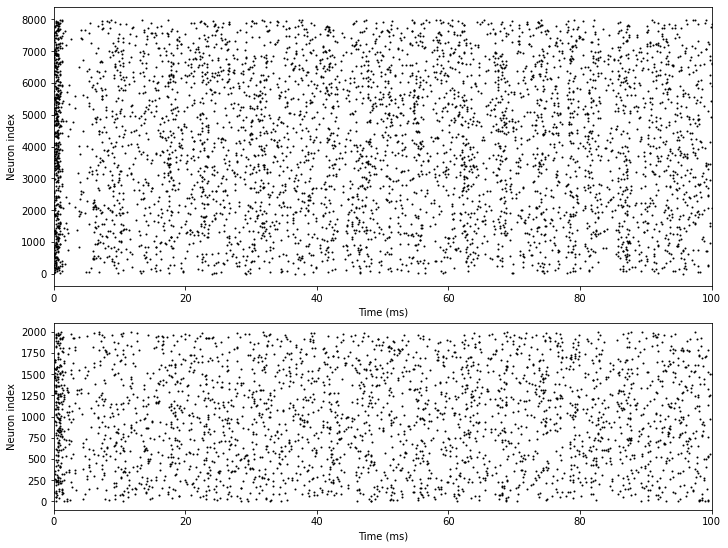

In [7]:
# visualization
fig, gs = bp.visualize.get_figure(5, 1, 1.5, 10)

fig.add_subplot(gs[:3, 0])
bp.visualize.raster_plot(runner.mon.ts, runner.mon['E.spike'], xlim=(0, 100))

fig.add_subplot(gs[3:, 0])
bp.visualize.raster_plot(runner.mon.ts, runner.mon['I.spike'], xlim=(0, 100), show=True)